In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.NeuralNetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Define Paramaters

In [2]:
base_seed = 42
base_feature_size = 15
baseline_accuracy = 0.9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Neural Network

In [3]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [4]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'module__layer_size': [32, 64],
    'module__layer_no': [1],
    'optimizer__weight_decay': [1e-3, 1e-4],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


c:\Users\Mihai\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1317, in

In [5]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 1024, 'max_epochs': 50, 'module__layer_no': 1, 'module__layer_size': 64, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.0001}
Best accuracy found:  0.9611666666666668


### Assesing performance

In [6]:
nn_results, unscaled_guarantee = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9618333333333333
Run 2 / 10 started
Run finished with test accuracy: 0.9658333333333333
Run 3 / 10 started
Run finished with test accuracy: 0.9526666666666667
Run 4 / 10 started
Run finished with test accuracy: 0.96
Run 5 / 10 started
Run finished with test accuracy: 0.9568333333333333
Run 6 / 10 started
Run finished with test accuracy: 0.958
Run 7 / 10 started
Run finished with test accuracy: 0.9635
Run 8 / 10 started
Run finished with test accuracy: 0.9608333333333333
Run 9 / 10 started
Run finished with test accuracy: 0.9595
Run 10 / 10 started
Run finished with test accuracy: 0.9576666666666667


In [7]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.693667        0.505417       0.961833
1     0      1    0.689576        0.541500       0.961833
2     0      2    0.656451        0.614042       0.961833
3     0      3    0.503338        0.737542       0.961833
4     0      4    0.333536        0.863875       0.961833


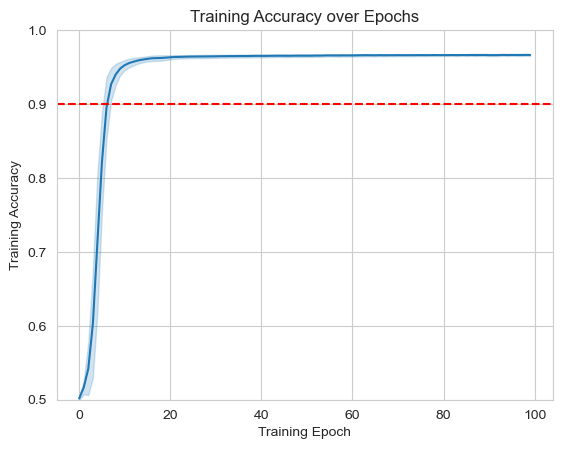

In [8]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

In [9]:
risk_tolerance = nn_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  

P(|E[r] - r_hat| > 0.05966666666666676) <= 0.01


# Random Forrests

In [10]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Assessing Performance

In [11]:
forrest_results, unscaled_guarantee = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.965
Run 2 / 10 started
Run finished with test accuracy: 0.9696666666666667
Run 3 / 10 started
Run finished with test accuracy: 0.967
Run 4 / 10 started
Run finished with test accuracy: 0.9676666666666667
Run 5 / 10 started
Run finished with test accuracy: 0.962
Run 6 / 10 started
Run finished with test accuracy: 0.9658333333333333
Run 7 / 10 started
Run finished with test accuracy: 0.9666666666666667
Run 8 / 10 started
Run finished with test accuracy: 0.9666666666666667
Run 9 / 10 started
Run finished with test accuracy: 0.9658333333333333
Run 10 / 10 started
Run finished with test accuracy: 0.9683333333333334


In [12]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.965000
1    1       0.969667
2    2       0.967000
3    3       0.967667
4    4       0.962000
5    5       0.965833
6    6       0.966667
7    7       0.966667
8    8       0.965833
9    9       0.968333


In [13]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.9664666666666667
Baseline to beat 0.9


In [14]:
risk_tolerance = forrest_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  

P(|E[r] - r_hat| > 0.06646666666666667) <= 0.00


# Logistic Regression

In [13]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Performing Grid Search

In [14]:
params = {
    'alpha': [0.1, 0.15, 0.2],
    'max_iter': [1500],
    'tol': [1e-3],
    'learning_rate': ['optimal', 'constant'],
    'eta0': [0.01, 0.001],
}

logreg = SGDClassifier(loss='log_loss', n_jobs=-1)

gs = GridSearchCV(logreg, params, refit=False, cv=10, scoring='accuracy', n_jobs=2, verbose=1)
clf = gs.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [15]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'optimal', 'max_iter': 1500, 'tol': 0.001}
Best accuracy found:  0.5370833333333334


### Assessing Performance

In [16]:
logreg_results = run_multiple_logistics(gs, base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.5261666666666667
Run 2 / 10 started
Run finished with test accuracy: 0.5451666666666667
Run 3 / 10 started
Run finished with test accuracy: 0.5328333333333334
Run 4 / 10 started
Run finished with test accuracy: 0.5341666666666667
Run 5 / 10 started
Run finished with test accuracy: 0.5423333333333333
Run 6 / 10 started
Run finished with test accuracy: 0.5396666666666666
Run 7 / 10 started
Run finished with test accuracy: 0.5375
Run 8 / 10 started
Run finished with test accuracy: 0.5316666666666666
Run 9 / 10 started
Run finished with test accuracy: 0.532
Run 10 / 10 started
Run finished with test accuracy: 0.5478333333333333


In [17]:
print(logreg_results)

os.makedirs('results', exist_ok=True)
logreg_results.to_csv(f'results/log_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.526167
1    1       0.545167
2    2       0.532833
3    3       0.534167
4    4       0.542333
5    5       0.539667
6    6       0.537500
7    7       0.531667
8    8       0.532000
9    9       0.547833


In [18]:
print("Logistic Regression Accuracy:", logreg_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Logistic Regression Accuracy: 0.5369333333333334
Baseline to beat 0.9
